In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset

In [68]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [69]:
# Define the data splits
train_end = '2018-12-31'
val_end = '2021-12-31'
# Everything after val_end will be used for backtesting

In [70]:
# Load and preprocess the data
df = pd.read_csv('data/REE.csv')
df['ngay'] = pd.to_datetime(df['ngay'])
df = df.sort_values('ngay')
df

,mack,ngay,open_root,high_root,low_root,close_root,volume_root,open_adjust,high_adjust,low_adjust,...,giatri_giaodich,ceilingprice,floorprice,changed,changedratio,kl_nn_ban,kl_nn_mua,gt_nn_ban,gt_nn_mua,lastupdate
5666,REE,2000-07-28 00:00:00+00:00,16000.0,16000.0,16000.0,16000.0,1000,1040.0,1040.0,1040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-03T14:22:25.598Z
5665,REE,2000-07-31 00:00:00+00:00,16300.0,16300.0,16300.0,16300.0,300,1060.0,1060.0,1060.0,...,NaN,NaN,NaN,20.0,1.92,NaN,NaN,NaN,NaN,2024-01-03T14:22:25.598Z
5664,REE,2000-08-02 00:00:00+00:00,16600.0,16600.0,16600.0,16600.0,100,1080.0,1080.0,1080.0,...,NaN,NaN,NaN,20.0,1.89,NaN,NaN,NaN,NaN,2024-01-03T14:22:25.598Z
5663,REE,2000-08-04 00:00:00+00:00,16900.0,16900.0,16900.0,16900.0,200,1100.0,1100.0,1100.0,...,NaN,NaN,NaN,20.0,1.85,NaN,NaN,NaN,NaN,2024-01-03T14:22:25.598Z
5662,REE,2000-08-07 00:00:00+00:00,17200.0,17200.0,17200.0,17200.0,2800,1120.0,1120.0,1120.0,...,NaN,NaN,NaN,20.0,1.82,NaN,NaN,NaN,NaN,2024-01-03T14:22:25.598Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,REE,2023-12-25 00:00:00+00:00,55800.0,56500.0,55700.0,56100.0,480200,47750.0,48350.0,47660.0,...,2.689120e+10,59700.0,51900.0,260.0,0.54,84700.0,43000.0,4.751670e+09,2.412300e+09,2024-05-26T21:36:37.868Z
3,REE,2023-12-26 00:00:00+00:00,56300.0,56400.0,55800.0,55800.0,622400,48170.0,48260.0,47750.0,...,3.487307e+10,60000.0,52200.0,-260.0,-0.54,139871.0,500.0,7.804802e+09,2.790000e+07,2024-05-26T21:36:37.868Z
2,REE,2023-12-27 00:00:00+00:00,55900.0,56500.0,55900.0,56400.0,527100,47830.0,48350.0,47830.0,...,2.966519e+10,59700.0,51900.0,510.0,1.07,50084.0,0.0,2.824738e+09,0.000000e+00,2024-05-26T21:36:37.868Z
1,REE,2023-12-28 00:00:00+00:00,56700.0,56800.0,56300.0,56400.0,346800,48520.0,48610.0,48170.0,...,1.958033e+10,60300.0,52500.0,0.0,0.00,0.0,18700.0,0.000000e+00,1.054680e+09,2024-05-26T21:36:37.868Z


In [71]:
# Select features and target
features = ['open_adjust', 'high_adjust', 'low_adjust', 'volume_adjust']
target = 'close_adjust'

In [54]:
# Scale the features and target
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])
scaled_data

array([[5.63961486e-03, 5.63961486e-03, 5.84545195e-03, 1.37869644e-04,
        5.69760978e-03],
       [5.91471802e-03, 5.91471802e-03, 6.13059595e-03, 3.29688280e-05,
        5.97554197e-03],
       [6.18982118e-03, 6.18982118e-03, 6.41573995e-03, 2.99716618e-06,
        6.25347415e-03],
       ...,
       [6.49243466e-01, 6.56396149e-01, 6.72939835e-01, 7.89783260e-02,
        6.61895497e-01],
       [6.58734525e-01, 6.59972490e-01, 6.77787283e-01, 5.19588729e-02,
        6.61895497e-01],
       [6.62173315e-01, 6.68225585e-01, 6.79070431e-01, 1.06717099e-01,
        6.66759311e-01]])

In [55]:
sequence_length = 10
X, y = [], []

for i in range(len(scaled_data) - sequence_length - 1):
    X.append(scaled_data[i:i+sequence_length, :-1])
    y.append(scaled_data[i+sequence_length, -1])

X = np.array(X)
y = np.array(y)



In [56]:
 # Split the data into train and test sets based on time
train_size = int(len(X) * 0.5)  # Use 80% of the data for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [57]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [58]:
# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [59]:
train_dataset

In [60]:
# Define the LSTM model
class StockPriceLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [61]:
# Initialize the model and trainer
model = StockPriceLSTM(input_size=len(features), hidden_size=64, num_layers=2)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5)
trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [62]:
# Train the model
trainer.fit(model, train_loader, test_loader)



  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 51.2 K | train
1 | fc   | Linear | 65     | train
----------------------------------------
51.3 K    Trainable params
0         Non-trainable params
51.3 K    Total params
0.205     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


c:\ProgramData\miniconda3\envs\an-project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\ProgramData\miniconda3\envs\an-project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 89/89 [00:00<00:00, 104.45it/s, v_num=4]


In [63]:
# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()


In [64]:
# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(np.column_stack((X_test[:, -1, :], predictions)))[:, -1]
actual = scaler.inverse_transform(np.column_stack((X_test[:, -1, :], y_test.numpy().reshape(-1, 1))))[:, -1]


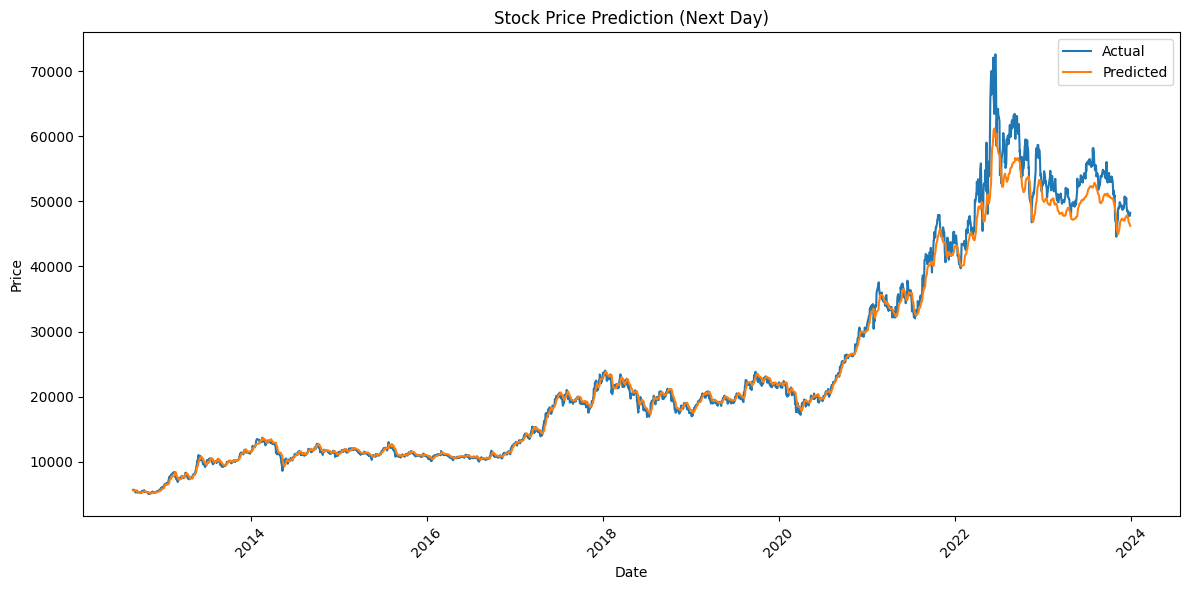

In [65]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['ngay'].iloc[-len(actual)-1:-1], actual, label='Actual')
plt.plot(df['ngay'].iloc[-len(predictions)-1:-1], predictions, label='Predicted')
plt.title('Stock Price Prediction (Next Day)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
# Calculate and print the Mean Absolute Error
mae = np.mean(np.abs(predictions - actual))
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 957.33
